In [1]:
pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installatio

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE_1=224
IMAGE_SIZE_2=224
BATCH_SIZE=32
EPOCHS=50
dataset_path = "/content/drive/MyDrive/PharmaScope"

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    image_size=(IMAGE_SIZE_1,IMAGE_SIZE_2),
    batch_size=BATCH_SIZE
)

Found 3495 files belonging to 27 classes.


In [5]:
class_names = dataset.class_names
class_names

['Albendazole',
 'Amoxicillin',
 'Beclovent dry powder capsule',
 'Bisacodyl',
 'Cephalexin',
 'Cetirizine',
 'Cypro',
 'Dexamethasone',
 'Diclofenac',
 'Domperidone',
 'Famotidine',
 'Flutihale dry powder capsule',
 'Folic acid',
 'Iprahale dry powder capsule',
 'Losatan',
 'Metformin',
 'Nifitepin',
 'Not Medicine',
 'Omeprazole',
 'Paracetamol',
 'Piriton',
 'Propranolol',
 'Salbutamol',
 'Salhale dry powder capsule',
 'Vitamin C',
 'Vitamin b-complex',
 'gastro resistant tablets']

In [6]:
def get_dataset_partions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size=len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size= int(train_split * ds_size)
    val_size= int(val_split * ds_size)

    train_ds= ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partions_tf(dataset)

In [10]:
len(test_ds)



11

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
from tensorflow.keras import layers
from tensorflow.keras import preprocessing

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE_1, IMAGE_SIZE_2),  # Removed 'experimental.preprocessing'
    layers.Rescaling(1.0/255),
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [14]:
CHANNELS=3
input_shape = (IMAGE_SIZE_1, IMAGE_SIZE_2, CHANNELS)

num_classes = 27

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=input_shape),
    layers.Conv2D(16, (3, 3), activation='relu'),  # Reduced filters
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),  # Reduced filters
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),  # Reduced dense layer units
    layers.Dense(num_classes, activation='softmax')
])

# Build the model with the correct input shape
model.build(input_shape=(None, IMAGE_SIZE_1, IMAGE_SIZE_2, CHANNELS))

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 93312)            

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
88/88 [==============================] - 439s 2s/step - loss: 1.4448 - accuracy: 0.6105 - val_loss: 0.3235 - val_accuracy: 0.9261
Epoch 2/50
88/88 [==============================] - 2s 19ms/step - loss: 0.1624 - accuracy: 0.9566 - val_loss: 0.0733 - val_accuracy: 0.9858
Epoch 3/50
88/88 [==============================] - 2s 19ms/step - loss: 0.0444 - accuracy: 0.9903 - val_loss: 0.0230 - val_accuracy: 0.9943
Epoch 4/50
88/88 [==============================] - 2s 19ms/step - loss: 0.1029 - accuracy: 0.9828 - val_loss: 0.0961 - val_accuracy: 0.9830
Epoch 5/50
88/88 [==============================] - 2s 19ms/step - loss: 0.0336 - accuracy: 0.9932 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 6/50
88/88 [==============================] - 2s 19ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 7/50
88/88 [==============================] - 2s 19ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 9.0696e-04 - val_accuracy: 1.0000
Epoch 8/5

In [ ]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 216s 10ms/step - loss: 7.1366e-04 - accuracy: 1.0000


In [ ]:
acc = history.history['accuracy']
val_acc=history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Traning and validation Loss')

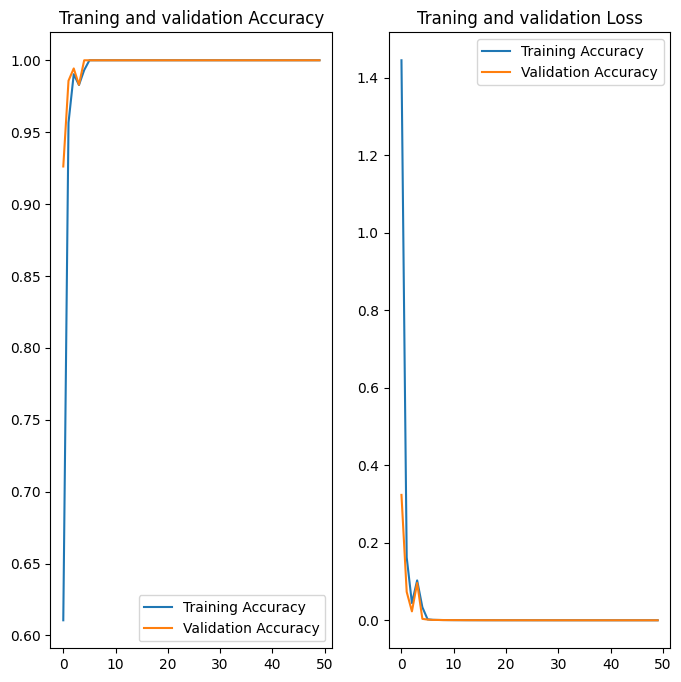

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Traning and validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Accuracy')
plt.plot(range(EPOCHS),val_loss,label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Traning and validation Loss')

In [ ]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
# Smooth the training and validation accuracy and loss
window_size = 5 # Adjust the window size for more or less smoothing
smooth_acc = moving_average(acc, window_size)
smooth_val_acc = moving_average(val_acc, window_size)
smooth_loss = moving_average(loss, window_size)
smooth_val_loss = moving_average(val_loss, window_size)

# Adjust the range to match the smoothed data
smooth_range = range(len(smooth_acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(smooth_range, smooth_acc, label='Training Accuracy')
plt.plot(smooth_range, smooth_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('raining and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(smooth_range, smooth_loss, label='Training Loss')
plt.plot(smooth_range, smooth_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


NameError: name 'np' is not defined

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
# Calculate metrics
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

conf_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_mat)

report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)


In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = conf_mat.max() / 2.
for i, j in np.ndindex(conf_mat.shape):
    plt.text(j, i, format(conf_mat[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_mat[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [ ]:
# Precision, recall, F1 score, and accuracy
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'Accuracy: {accuracy}')

In [ ]:
# Save the model
import os
model.save(f"/content/drive/MyDrive/CorrectModels/normal.h5") # Add .keras extension